In [2]:
import importlib
import micasense.capture
import cv2
import os, glob
import json
import pickle #This library will maintain the format as well
from osgeo import gdal,osr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
import PIL.Image as Image
import datetime
from math import ceil
from tqdm import tqdm
import re
from PIL import Image
import contextlib

import cameratransform as ct
import rasterio

import algorithms.flight_attributes
import algorithms.validate_algorithm
import algorithms.select_GPS as SelectGPS
import algorithms.georeferencing
import algorithms.alignment_error
import algorithms.plot_map
import algorithms.mutils as mutils

importlib.reload(algorithms.flight_attributes)
importlib.reload(algorithms.georeferencing)
importlib.reload(algorithms.alignment_error)
importlib.reload(algorithms.plot_map)

import algorithms.flight_attributes as FlightAttributes
import algorithms.georeferencing as georeferencing
import algorithms.alignment_error as alignment_error
import algorithms.plot_map as plot_map

# README

This python notebook assesses the accuracy of direct-georeferencing and orthomosaicked image by comparing it with a reference map (high-resolution satellite imagery obtained from google map tiles). Specifically, to assess the similarity between the reference map and the UAV imagery, the cosine similarity is used.

This also allows quick preview of the quality of the orthomosaic and the accuracy of the direct-georeferencing against the ground truth.

To obtain a high-resolution satellite imagery obtained from google map tiles given known corner coordinates, refer to the instructions in [pakhuiying/aerialbot](https://github.com/pakhuiying/aerialbot), which is forked from [doersino/aerialbot](https://github.com/doersino/aerialbot).

**Sensor used**: MicaSense's 10-Band Dual Camera System

![MicaSense's Dual Camera System](plots/camera%20parameters.png)

# Plot High-resolution Satellite Imagery

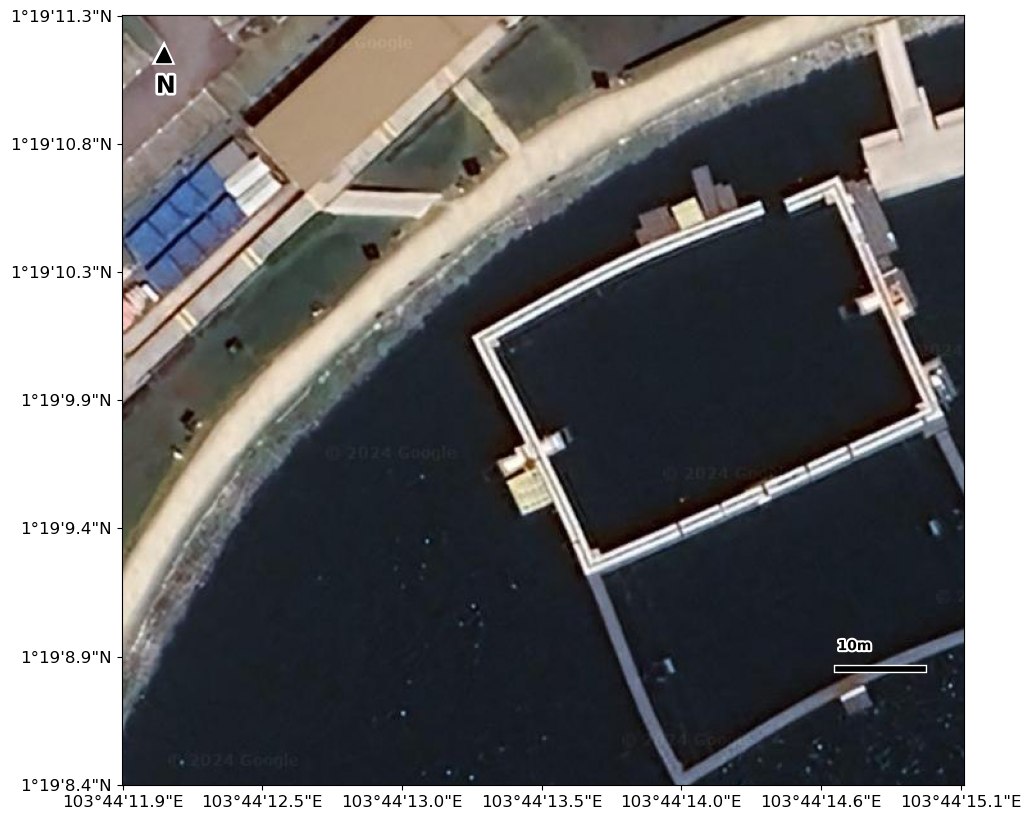

In [3]:
# Import high-resolution satellite imagery obtained from google tile
canvas = np.asarray(Image.open(r"plots\aerialbot-2024-02-11T17.00.57-downward-1.319335,103.737142-2000x2000m-z20.jpg"))
sw_point = (1.319000, 103.736650)
ne_point = (1.319806, 103.737532)
PM = plot_map.PlotMap(ne_point,sw_point,canvas)
PM.plot()

# Import data

In [5]:
# directory which contains the raw images, band-aligned images, rgb thumbnails, metadata
imagePath = r"D:\EPMC_flight\pandanRes\00angle_15H_50overlap"

# directory which contains raw images
rawImagePath = os.path.join(imagePath,'RawImg') # We created a new folder called RawImg to store all the raw images here

# file that contains the metadata of each captures
flightAttributesPath = os.path.join(imagePath,'flight_attributes','flight_attributes.csv')

# import metadata as a pandas dataframe
if os.path.exists(flightAttributesPath):
    log = pd.read_csv(flightAttributesPath)
print(log.head())

# import GPS coordinates selected using algorithms/select_GPS.py
flight_points = SelectGPS.readSelectedGPS(rawImagePath)

# import height information of flight
height_dict = FlightAttributes.get_heights(imagePath,log)

                          timestamp  latitude   longitude  altitude  \
0  2023-09-20 02:37:46.734108+00:00  1.318984  103.736576    30.643   
1  2023-09-20 02:38:25.652070+00:00  1.318969  103.736552    31.828   
2  2023-09-20 02:40:02.646889+00:00  1.318935  103.736667    31.825   
3  2023-09-20 02:40:27.129650+00:00  1.318957  103.736711    43.093   
4  2023-09-20 02:40:28.687747+00:00  1.318989  103.736740    43.126   

       image_name            capture_id   dls-yaw  dls-pitch  dls-roll  \
0  IMG_0000_1.tif  iRMg5hgGW1CUYi1x0TlZ  0.635662  -0.207969 -0.047398   
1  IMG_0001_1.tif  ws9iE0ctR0GdjP9XYeKY  1.768777  -0.081365 -0.034487   
2  IMG_0002_1.tif  o34Xx90IfaznKeSuG8Bq  1.807706  -0.066323 -0.019898   
3  IMG_0003_1.tif  9uaW8y0N0EE0vgF9zbKj  0.603067  -0.147849  0.018589   
4  IMG_0004_1.tif  573tCs56BPBA8nQJo06y  0.632837  -0.131004  0.014908   

    irr-475   irr-560   irr-668   irr-842   irr-717   irr-444   irr-531  \
0  0.744841  0.663156  0.547643  0.342493  0.428046  

## Helper functions to modify the metadata

Custom functions to define whether the image mosaicking should use the yaw readings or the UAV heading

In [6]:
def modify_df(df_cropped, DEM_offset_height):
    #----------------append flight angle---------------------------------------------
    df_cropped.loc[:,['flight_angle']] = -df_cropped['dls-yaw']/np.pi*180
    # ---- instead of using yaw, use the heading of the UAV----------
    reclassify_angles = lambda x: -180 if x < -160 else 0
    reclassified_angles = [reclassify_angles(i) for i in df_cropped['flight_angle'].to_list()]
    df_cropped.loc[:,['flight_angle']] = reclassified_angles
    #-----------adjust UAV's altitude instead of using GPS's altitude reading--------
    df_cropped.loc[:,['altitude']] = df_cropped.loc[:,['altitude']] - DEM_offset_height
    return df_cropped

def modify_df_yaw(df_cropped, DEM_offset_height):
    #----------------append flight angle---------------------------------------------
    df_cropped.loc[:,['flight_angle']] = -df_cropped['dls-yaw']/np.pi*180
    #-----------adjust UAV's altitude instead of using GPS's altitude reading--------
    # accounts for the take-off altitude
    df_cropped.loc[:,['altitude']] = df_cropped.loc[:,['altitude']] - DEM_offset_height
    return df_cropped

In [7]:
# get the take-off height altitude
height_min = height_dict['height_min']
DEM_offset_height = height_min

# subset the metadata based on selected flight points
df_cropped = log.iloc[flight_points,:]

df_cropped = modify_df(df_cropped, DEM_offset_height)
df_cropped

,timestamp,latitude,longitude,altitude,image_name,capture_id,dls-yaw,dls-pitch,dls-roll,irr-475,irr-560,irr-668,irr-842,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740,flight_angle
10,2023-09-20 02:40:46.867245+00:00,1.319223,103.736855,17.528,IMG_0010_1.tif,TGMjtoMK4lZZHwz0gWE2,0.098322,-0.067554,-0.011150,0.389261,0.336241,0.263961,0.165486,0.207043,0.357777,0.352711,0.264435,0.233321,0.214836,0.0
11,2023-09-20 02:40:48.333197+00:00,1.319285,103.736855,17.650,IMG_0011_1.tif,Vbmk53xTHky4YeQ3tY5q,0.105641,-0.061187,-0.012180,0.388711,0.335740,0.263521,0.165222,0.206712,0.357304,0.352196,0.264010,0.232936,0.214483,0.0
12,2023-09-20 02:40:49.529728+00:00,1.319329,103.736855,17.519,IMG_0012_1.tif,sHfimxse9xw3yckAG5jT,0.108555,-0.092849,-0.016617,0.388261,0.335334,0.263198,0.165027,0.206479,0.356898,0.351778,0.263695,0.232662,0.214233,0.0
13,2023-09-20 02:40:50.856883+00:00,1.319371,103.736854,17.435,IMG_0013_1.tif,JTvwKvY3Wp1QRFABs177,0.120106,-0.088623,-0.023227,0.387690,0.334802,0.262754,0.164750,0.206159,0.356389,0.351234,0.263266,0.232289,0.213892,0.0
14,2023-09-20 02:40:52.169954+00:00,1.319422,103.736854,17.352,IMG_0014_1.tif,GSCS3gkaTUELPKSWJdea,0.124905,-0.094922,-0.029860,0.387213,0.334354,0.262390,0.164522,0.205883,0.355956,0.350776,0.262902,0.231979,0.213612,0.0
15,2023-09-20 02:40:53.589501+00:00,1.319472,103.736854,17.289,IMG_0015_1.tif,a9W6IeTeApFvdy6YZmoD,0.129650,-0.112619,-0.032220,0.386693,0.333877,0.262015,0.164282,0.205592,0.355474,0.350284,0.262523,0.231655,0.213320,0.0
19,2023-09-20 02:41:02.187689+00:00,1.319453,103.736917,17.578,IMG_0019_1.tif,JMwCyxZYTwIaNl8s1JqS,3.134863,-0.181926,-0.043723,0.383928,0.332671,0.260078,0.163659,0.204055,0.353862,0.348756,0.261007,0.229503,0.210897,-180.0
20,2023-09-20 02:41:03.520863+00:00,1.319400,103.736917,17.528,IMG_0020_1.tif,rvW1ZR6L15nzlWYzQv47,3.107451,-0.123240,-0.022599,0.382603,0.331665,0.259325,0.163180,0.203390,0.352640,0.347652,0.260238,0.228773,0.210203,-180.0
21,2023-09-20 02:41:04.723871+00:00,1.319355,103.736917,17.460,IMG_0021_1.tif,9QsYgvMByLtvzwrE8a76,3.078801,-0.140075,-0.019666,0.381419,0.330739,0.258621,0.162748,0.202787,0.351560,0.346650,0.259524,0.228103,0.209575,-180.0
22,2023-09-20 02:41:05.909510+00:00,1.319319,103.736917,17.390,IMG_0022_1.tif,k69jmBnbJCmeLakHMOcd,3.057578,-0.132865,-0.017881,0.380082,0.329648,0.257777,0.162212,0.202077,0.350332,0.345482,0.258667,0.227319,0.208846,-180.0


In [8]:
PG = FlightAttributes.PlotGeoreference(imagePath,df_cropped)
geotransform_list = PG.get_flight_attributes()
print(geotransform_list)

{10: {'lat': 1.3192234, 'lon': 103.7368554, 'lat_res': 1.0628677378960366e-07, 'lon_res': 1.0631495350475142e-07, 'flight_angle': 0.0, 'image_fp': 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0010_1.jpg'}, 11: {'lat': 1.3192848, 'lon': 103.7368553, 'lat_res': 1.0702656078197768e-07, 'lon_res': 1.070549392781877e-07, 'flight_angle': 0.0, 'image_fp': 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0011_1.jpg'}, 12: {'lat': 1.3193286, 'lon': 103.7368548, 'lat_res': 1.0623219933934656e-07, 'lon_res': 1.0626036907840427e-07, 'flight_angle': 0.0, 'image_fp': 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0012_1.jpg'}, 13: {'lat': 1.3193714, 'lon': 103.7368543, 'lat_res': 1.0572283780361363e-07, 'lon_res': 1.0575087429393181e-07, 'flight_angle': 0.0, 'image_fp': 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0013_1.jpg'}, 14: {'lat': 1.3194217, 'lon': 103.736854, 'lat_res': 1.0521954009568703e-07, 'lon_res': 

# Plot UAV imagery on-top of reference map (without correction)

[]

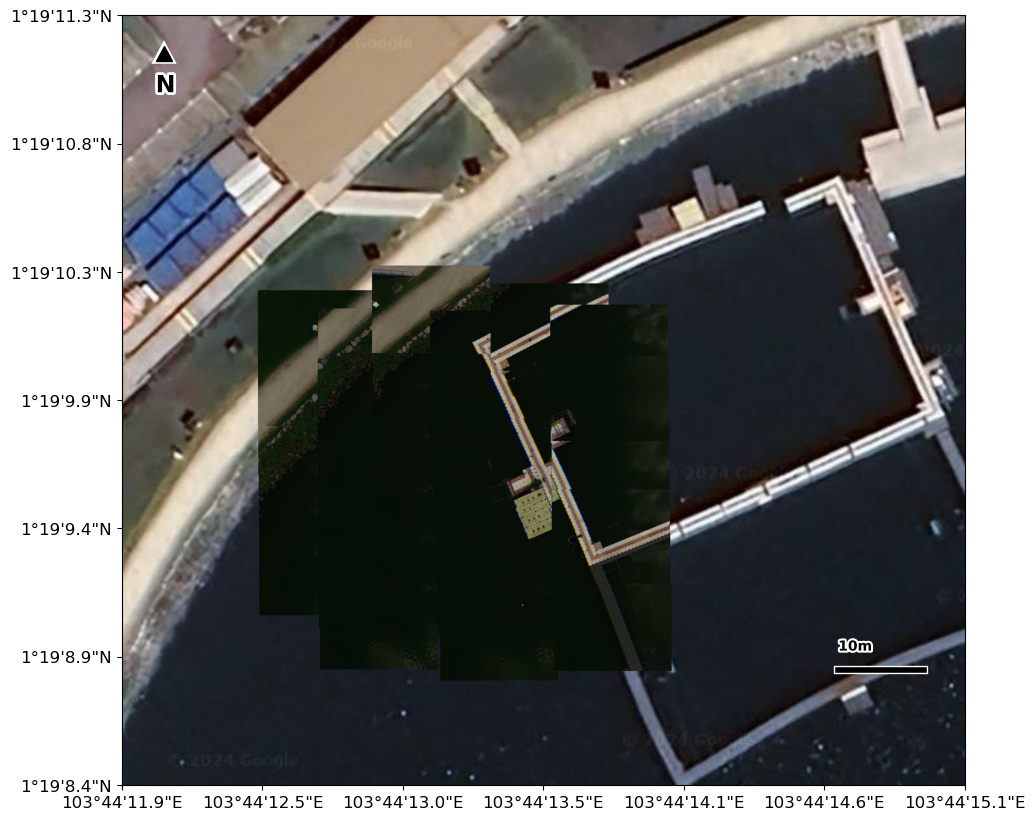

In [9]:
GR = georeferencing.GeoreferenceRaster(ne_point,sw_point,canvas,geotransform_list)
GR.plot()

# Batch process images

In [10]:
rootDir = r"D:\EPMC_flight\pandanRes"
dirsList = [os.path.join(rootDir,f) for f in sorted(os.listdir(rootDir)) if f.endswith("overlap")]
dirsList

['D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_60overlap',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_70overlap',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_80overlap',
 'D:\\EPMC_flight\\pandanRes\\00angle_25H_50overlap',
 'D:\\EPMC_flight\\pandanRes\\00angle_25H_60overlap',
 'D:\\EPMC_flight\\pandanRes\\00angle_25H_70overlap',
 'D:\\EPMC_flight\\pandanRes\\00angle_25H_80overlap',
 'D:\\EPMC_flight\\pandanRes\\00angle_35H_50overlap',
 'D:\\EPMC_flight\\pandanRes\\00angle_35H_60overlap',
 'D:\\EPMC_flight\\pandanRes\\00angle_35H_70overlap',
 'D:\\EPMC_flight\\pandanRes\\00angle_35H_80overlap',
 'D:\\EPMC_flight\\pandanRes\\45angle_15H_50overlap',
 'D:\\EPMC_flight\\pandanRes\\45angle_15H_60overlap',
 'D:\\EPMC_flight\\pandanRes\\45angle_15H_70overlap',
 'D:\\EPMC_flight\\pandanRes\\45angle_15H_80overlap',
 'D:\\EPMC_flight\\pandanRes\\45angle_25H_50overlap',
 'D:\\EPMC_flight\\pandanRes\\45angle_25H_60overlap',
 'D:\\EPMC_flight\\pandanRes

## Image alignment using time delay correction
- attempts various corrections on flight altitude (e.g. if the water body is at a lower altitude than the take off point of drone)
- attempts different time delay correction

In [ ]:
BC = georeferencing.BatchCorrect(imagePath,dirName="UAVHeadingTimeDelay1")
BC.main_timeDelay(modify_df,ne_point,sw_point,canvas, calculate_correlation=True)

## Image alignment using coordinate shift
- attempts various corrections on flight altitude (e.g. if the water body is at a lower altitude than the take off point of drone)
- attempts different coordinate shift correction

In [ ]:
BC = georeferencing.BatchCorrect(imagePath,dirName="UAVHeadingShiftCoord2")
BC.main_shiftCoord(modify_df,ne_point,sw_point,canvas, calculate_correlation=True)

# Comparison with MosaicSeadron

In [ ]:
df_cropped1 = modify_df_yaw(log, DEM_offset_height=log['altitude'].min())
df_cropped1 = df_cropped1.iloc[flight_points,:]

MosaicSeadron_geotransform_list = georeferencing.get_MosaicSeadron_geotransform_list(imagePath,df_cropped1,'MosaicSeadron_uncorrected')

In [ ]:
GR = georeferencing.GeoreferenceRaster(ne_point,sw_point,canvas,MosaicSeadron_geotransform_list)
GR.plot(calculate_correlation=True) # calculate cosine similarity if calculate_correlation = True

In [ ]:
class BatchCorrectMosaicSeadron:
    def __init__(self,imagePath,dirName):
        """ 
        :param imagePath (str): directory to image folder
        :param dirName (str): name of directory folder
        """
        self.imagePath = imagePath
        self.rawImagePath = os.path.join(imagePath,'RawImg')
        self.flightAttributesPath = os.path.join(imagePath,'flight_attributes','flight_attributes.csv')
        self.log = pd.read_csv(self.flightAttributesPath)
        self.height_dict = FlightAttributes.get_heights(imagePath,self.log)
        self.flight_points = SelectGPS.readSelectedGPS(self.rawImagePath)
        self.dirName = dirName
    
    def save_data(self,dirPath,fileName, data):
        save_fp = os.path.join(dirPath,f'{fileName}.ob')
        with open(save_fp,'wb') as fp:
            pickle.dump(data,fp)
        return
    
    def main(self,modify_df,ne_point,sw_point,canvas, calculate_correlation=True):
        height_steps = 6
        height_dict = dict()
        # for height in range(2):
        for height in range(height_steps): # try offsets in height of up to 5m by 1meters
            DEM_offset_height = self.height_dict['DEM_offset_height'] - height
            log = self.log.copy()
            df_cropped = modify_df(log, DEM_offset_height=DEM_offset_height)
            df_cropped = df_cropped.iloc[self.flight_points,:]
            MosaicSeadron_geotransform_list = georeferencing.get_MosaicSeadron_geotransform_list(self.imagePath,df_cropped,self.dirName)
            # print(MosaicSeadron_geotransform_list)
            GR = georeferencing.GeoreferenceRaster(ne_point,sw_point,canvas,
                                                MosaicSeadron_geotransform_list)
            # plot
            fig, ax = plt.subplots(1,1,figsize=(12,10))
            cc_list = GR.plot(ax=ax,calculate_correlation=calculate_correlation)
            # add fig title
            correctedHeight = int(self.height_dict['measuredHeight'] - DEM_offset_height)
            ax.set_title(f"Height: {self.height_dict['actualHeight']}m, Corrected height: {correctedHeight}m",
                        fontdict={'fontsize': 15, 'fontweight': 'medium'})
            
            plt.show()
            # save cc list
            height_dict[correctedHeight] = cc_list
            # save fig
            parentDir = os.path.join(self.imagePath,"images",self.dirName)
            os.mkdir(parentDir) if not os.path.exists(parentDir) else None
            fname = os.path.join(parentDir,f'offsetHeight{int(DEM_offset_height)}.png')
            fig.savefig(fname)
        
        # save cc list on disk
        self.save_data(parentDir,'cc_list',height_dict)
        return


canvas = np.asarray(Image.open(r"plots\aerialbot-2024-02-11T17.00.57-downward-1.319335,103.737142-2000x2000m-z20.jpg"))
sw_point = (1.319000, 103.736650)
ne_point = (1.319806, 103.737532)

BCMS = BatchCorrectMosaicSeadron(imagePath,dirName="UAVHeadingMosaicSeadron")
BCMS.main(modify_df,ne_point,sw_point,canvas, calculate_correlation=True)

In [ ]:
canvas = np.asarray(Image.open(r"plots\aerialbot-2024-02-11T17.00.57-downward-1.319335,103.737142-2000x2000m-z20.jpg"))
sw_point = (1.319000, 103.736650)
ne_point = (1.319806, 103.737532)

for selectedIdx in range(12): #12
    imagePath = dirsList[selectedIdx]
    print(imagePath)
    BCMS = BatchCorrectMosaicSeadron(imagePath,dirName="UAVHeadingMosaicSeadron")
    BCMS.main(modify_df,ne_point,sw_point,canvas, calculate_correlation=True)

# Select the most optimal georeferenced image based on cosine correlation

offset height: 15m
[11, 22, 26, 36, 40, 51, 55, 66, 69, 80, 84, 94, 98, 109, 113, 123, 128, 138, 142, 152]
offset height: 15m
[11, 22, 26, 36, 40, 51, 55, 66, 69, 80, 84, 94, 98, 109, 113, 123, 128, 138, 142, 152]


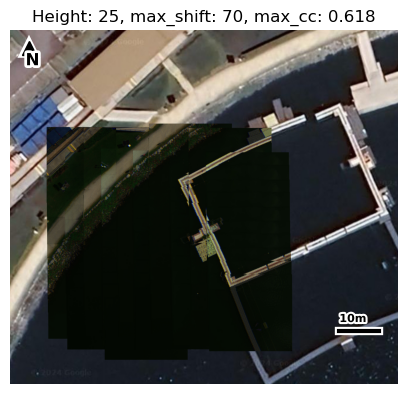

In [32]:
class fetchOptimalGeoreferencedImage:
    """ 
    Based on the highest cosine similarity score, obtain the most optimal georeferenced image
    """
    def __init__(self,imagePath,dirName):
        """ 
        :param imagePath (str): directory to image folder
        :param dirName (str): name of directory folder
        """
        self.imagePath = imagePath
        self.rawImagePath = os.path.join(imagePath,'RawImg')
        self.flightAttributesPath = os.path.join(imagePath,'flight_attributes','flight_attributes.csv')
        self.log = pd.read_csv(self.flightAttributesPath)
        self.height_dict = FlightAttributes.get_heights(imagePath,self.log)
        self.flight_points = SelectGPS.readSelectedGPS(self.rawImagePath)
        self.dirName = dirName
        self.cc_fp = os.path.join(imagePath,'images','UAVHeadingShiftCoord2','cc_list.ob')
    
    def get_highest_cc(self):
        """ 
        returns corrected height: {shift: highest average cc}
        """
        cc_list = mutils.load_pickle(self.cc_fp)
        height_dict = dict()
        for height, h_dict in cc_list.items():
            max_cc_avg = 0
            max_shift = 0
            for shift, shift_list in h_dict.items():
                cc_avg = np.mean([s[1] for s in shift_list])
                if cc_avg > max_cc_avg:
                    max_cc_avg = cc_avg
                    max_shift = shift
            height_dict[height] = {max_shift: max_cc_avg}

        height_list = list(height_dict.values())
        height = 0
        max_cc = 0
        max_shift = 0
        for i, shift_dict in enumerate(height_list):
            if list(shift_dict.values())[0] > max_cc:
                max_cc = list(shift_dict.values())[0]
                height = i
                max_shift = list(shift_dict)[0]
        DEM_offset_height = self.height_dict['DEM_offset_height'] - height
        return DEM_offset_height, max_shift, max_cc
    
    def plot_params(self, PM, ax, title):
        """ 
        :param PM (PlotMap class)
        """
        tickFontSize = 7
        tick_breaks = 4
        NorthFontSize = 12
        triangleFontSize = 10
        scaleBarFontSize = 8
        scaleBarWidth = 3
        title_fontSize = 12

        PM.plot(ax=ax,add_ticks=False,add_compass=False,add_scale_bar=False)
                
        # set compass
        PM.add_compass(ax=ax,fontsize_N=NorthFontSize,fontsize_triangle=triangleFontSize)
        # set north
        PM.add_scale_bar(ax=ax,fontsize=scaleBarFontSize,lw=scaleBarWidth)
        # set subfigure title
        ax.set_title(f'{title}',
                     fontdict={'fontsize': title_fontSize, 'fontweight': 'medium'})
        return
    
    def coord_shift(self, modify_df,ne_point,sw_point,canvas):
        DEM_offset_height, max_shift, max_cc = self.get_highest_cc()
        BC = georeferencing.BatchCorrect(self.imagePath,self.dirName)
        BC.get_distance_interpolation()
        df_cropped = BC.shift_coord(max_shift)
        df_cropped = modify_df(df_cropped, DEM_offset_height)
        
        # plot
        fig, ax = plt.subplots(1,1,figsize=(5,5))
        im_display, _ = BC.georeference_UAV(ne_point, sw_point, canvas, 
                                                                df_cropped, 
                                                                calculate_correlation=False)
        PM = plot_map.PlotMap(ne_point,sw_point,im_display)
        # add plot params
        correctedHeight = int(self.height_dict['measuredHeight'] - DEM_offset_height)
        self.plot_params(PM, ax, title=f'Height: {correctedHeight}, max_shift: {max_shift}, max_cc: {max_cc:.3f}')
        ax.axis('off')
        plt.show()

        # save fig
        parentDir = os.path.join(self.imagePath,"images",self.dirName)
        os.mkdir(parentDir) if not os.path.exists(parentDir) else None
        fname = os.path.join(parentDir,f'{os.path.basename(self.imagePath)}_coordShift.png')
        fig.savefig(fname)
        return
    
    def mosaicSeadron(self, modify_df,ne_point,sw_point,canvas):
        DEM_offset_height, _, _ = self.get_highest_cc()
        log = self.log.copy()
        df_cropped = modify_df(log, DEM_offset_height=DEM_offset_height)
        df_cropped = df_cropped.iloc[self.flight_points,:]
        MosaicSeadron_geotransform_list = georeferencing.get_MosaicSeadron_geotransform_list(self.imagePath,df_cropped,self.dirName)
        # print(MosaicSeadron_geotransform_list)
        GR = georeferencing.GeoreferenceRaster(ne_point,sw_point,canvas,
                                            MosaicSeadron_geotransform_list)
        # plot
        fig, ax = plt.subplots(1,1,figsize=(5,5))
        im_display, _ = GR.georeference_UAV(calculate_correlation=False)
        PM = plot_map.PlotMap(ne_point,sw_point,im_display)
        # add plot params
        correctedHeight = int(self.height_dict['measuredHeight'] - DEM_offset_height)
        self.plot_params(PM, ax, title=f'Height: {correctedHeight}')
        ax.axis('off')
        plt.show()

        # save fig
        parentDir = os.path.join(self.imagePath,"images",self.dirName)
        os.mkdir(parentDir) if not os.path.exists(parentDir) else None
        fname = os.path.join(parentDir,f'{os.path.basename(self.imagePath)}_mosaicSeadron.png')
        fig.savefig(fname)

        return

canvas = np.asarray(Image.open(r"plots\aerialbot-2024-02-11T17.00.57-downward-1.319335,103.737142-2000x2000m-z20.jpg"))
sw_point = (1.319000, 103.736650)
ne_point = (1.319806, 103.737532)

for selectedIdx in range(1,12): #12
    imagePath = dirsList[selectedIdx]
    print(imagePath)
    FOGI = fetchOptimalGeoreferencedImage(imagePath,dirName="comparisons")
    FOGI.coord_shift(modify_df,ne_point,sw_point,canvas)
    FOGI.mosaicSeadron(modify_df,ne_point,sw_point,canvas)

# Plot cosine similarity comparison across different methods

offset height: 25m
[5, 8, 12, 14, 18, 21, 25, 28]
(29, 0.6728901613775696)
(29, 0.12392838489094565)
(0.0, 0.7065346694464482)


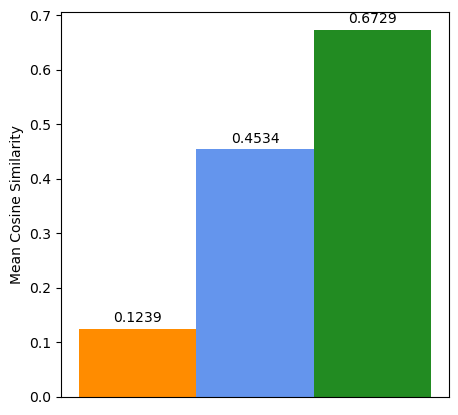

In [5]:
class CosineSimilarityComparison:
    def __init__(self,imagePath,dirName):
        """ 
        :param imagePath (str): directory to image folder
        :param dirName (str): name of directory folder
        """
        self.imagePath = imagePath
        self.rawImagePath = os.path.join(imagePath,'RawImg')
        self.flightAttributesPath = os.path.join(imagePath,'flight_attributes','flight_attributes.csv')
        self.log = pd.read_csv(self.flightAttributesPath)
        self.height_dict = FlightAttributes.get_heights(imagePath,self.log)
        self.flight_points = SelectGPS.readSelectedGPS(self.rawImagePath)
        self.dirName = dirName
        self.cc_fp = os.path.join(imagePath,'images','UAVHeadingShiftCoord2','cc_list.ob')
        self.cc_MosaicSeadron_fp = os.path.join(imagePath,'images','UAVHeadingMosaicSeadron','cc_list.ob')
    
    def get_cc(self):
        cc_list = mutils.load_pickle(self.cc_fp)
        return cc_list
    
    def get_cc_MosaicSeadron(self):
        cc_list = mutils.load_pickle(self.cc_MosaicSeadron_fp)
        max_height, _ = self.get_best_cc()
        shift_list = cc_list[max_height]
        cc_avg = np.mean([s[1] for s in shift_list])
        return max_height, cc_avg
    
    def get_best_cc(self):
        cc_list = self.get_cc()
        max_cc_avg = 0
        max_height = 0
        for height, h_dict in cc_list.items():
            for shift, shift_list in h_dict.items():
                cc_avg = np.mean([s[1] for s in shift_list])
                if cc_avg > max_cc_avg:
                    max_cc_avg = cc_avg
                    max_height = height
        return max_height, max_cc_avg
    
    def get_original_cc(self):
        max_height, max_cc_avg = self.get_best_cc()
        cc_list = self.get_cc()
        shift_list = cc_list[max_height][0]
        cc_avg = np.mean([s[1] for s in shift_list])
        return max_height, cc_avg
    
    def bar_plot(self,ax=None):
        width = 1  # the width of the bars
        cc_dict = {'MosaicSeadron': self.get_cc_MosaicSeadron()[1],
                   'No image alignment': self.get_original_cc()[1],
                   'Image alignment': self.get_best_cc()[1]}
        cols = ['darkorange','cornflowerblue','forestgreen']

        x = np.arange(len(list(cc_dict)))  # the label locations

        if ax is None:
            fig, ax = plt.subplots(1,1,figsize=(5,5))
        
        for i, ((method, cc),col) in enumerate(zip(cc_dict.items(),cols)):
            ax.set_ylabel('Mean Cosine Similarity')
            rects = ax.bar(x[i],cc,width,label=method, color=col)
            ax.bar_label(rects, padding=3, fmt = '%04.4f')
        ax.set_xticks([])
        print(ax.get_ylim())
        if ax is None:
            plt.show()
        return


CSC = CosineSimilarityComparison(imagePath, "test")
print(CSC.get_best_cc())
print(CSC.get_cc_MosaicSeadron())
CSC.get_original_cc()
CSC.bar_plot()

D:\EPMC_flight\pandanRes\00angle_15H_50overlap
[10, 15, 19, 25, 29, 35, 39, 45, 49, 55, 59, 65]
offset height: 26m
[10, 15, 19, 25, 29, 35, 39, 45, 49, 55, 59, 65]
(0.0, 0.4860462810430533)
D:\EPMC_flight\pandanRes\00angle_25H_50overlap
[5, 8, 12, 14, 18, 21, 25, 28]
offset height: 25m
[5, 8, 12, 14, 18, 21, 25, 28]
(0.0, 0.7065346694464482)
D:\EPMC_flight\pandanRes\00angle_35H_50overlap
[7, 9, 12, 14]
offset height: 26m
[7, 9, 12, 14]
(0.0, 0.6639406510386364)
D:\EPMC_flight\pandanRes\00angle_15H_60overlap
[8, 16, 21, 29, 33, 41, 46, 54, 58, 66, 70, 79, 83, 91, 95, 104]
offset height: 15m
[8, 16, 21, 29, 33, 41, 46, 54, 58, 66, 70, 79, 83, 91, 95, 104]
(0.0, 0.4638340170795331)
D:\EPMC_flight\pandanRes\00angle_25H_60overlap
[5, 9, 13, 17, 21, 25, 29, 33, 37, 41]
offset height: 14m
[5, 9, 13, 17, 21, 25, 29, 33, 37, 41]
(0.0, 0.41441707490431845)
D:\EPMC_flight\pandanRes\00angle_35H_60overlap
[6, 8, 12, 14, 18, 20]
offset height: 23m
[6, 8, 12, 14, 18, 20]
(0.0, 0.35283229681980227)
D:

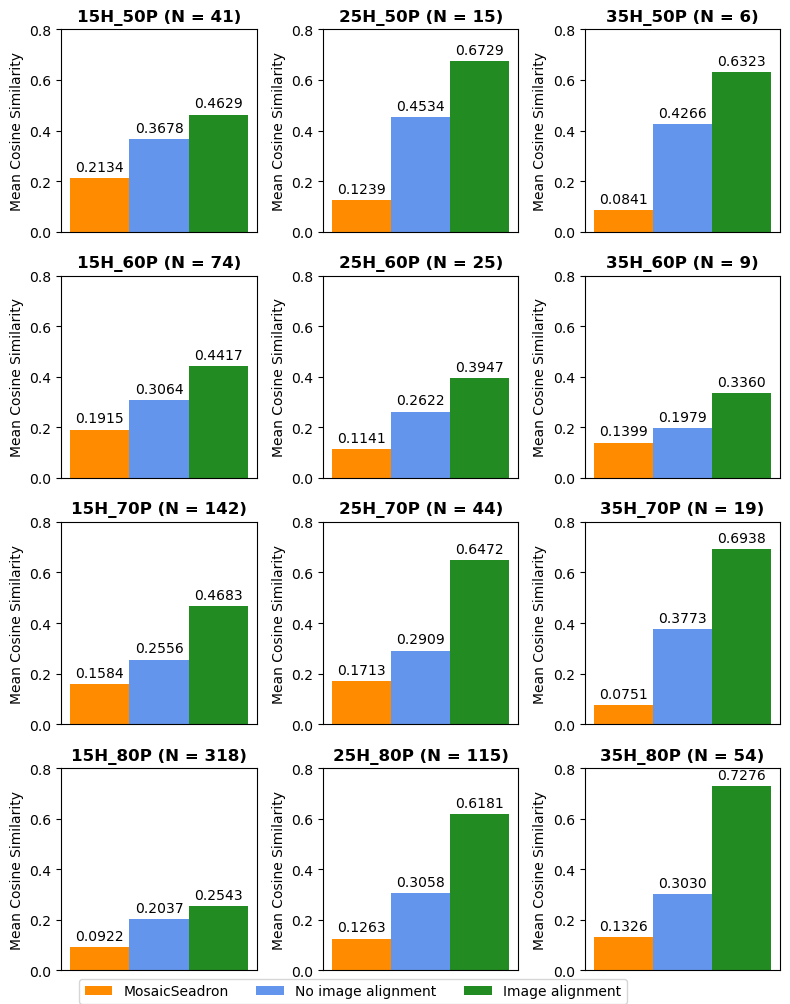

In [6]:
def barplot_grid():
    titles = [f'{h:02d}H_{p}P' for p in np.arange(50,90,step=10,dtype=int) for h in np.arange(15,45,step=10,dtype=int)]
    fp_list = [os.path.join(r"D:\EPMC_flight\pandanRes",f'00angle_{t.replace("P","overlap")}' ) for t in titles]
    title_fontSize = 12
    fig, axes = plt.subplots(4,3,figsize=(8,10))
    for i, ax in enumerate(axes.flatten()):
        imagePath = fp_list[i]
        print(imagePath)
        rawImagePath = os.path.join(imagePath,'RawImg')
        flight_points = SelectGPS.readSelectedGPS(rawImagePath)
        CSC = CosineSimilarityComparison(imagePath, "test")
        CSC.bar_plot(ax)
        ax.set_title(f'{titles[i]} (N = {len(flight_points)})' ,
                     fontdict={'fontsize': title_fontSize, 'fontweight': 'bold'})
        ax.set_ylim((0,0.8))
    
    handles, labels = ax.get_legend_handles_labels()
    
    plt.tight_layout()
    fig.legend(handles, labels, loc=(0.1,0.0),ncol=3)
    plt.show()
    return
barplot_grid()

In [6]:
def get_highest_cc(fp):
    """ 
    returns corrected height: {shift: highest average cc}
    """
    cc_list = mutils.load_pickle(fp)
    height_dict = dict()
    for height, h_dict in cc_list.items():
        max_cc_avg = 0
        max_shift = 0
        for shift, shift_list in h_dict.items():
            cc_avg = np.mean([s[1] for s in shift_list])
            if cc_avg > max_cc_avg:
                max_cc_avg = cc_avg
                max_shift = shift
        height_dict[height] = {max_shift: max_cc_avg}
    return height_dict

get_highest_cc(r"D:\EPMC_flight\pandanRes\00angle_15H_80overlap\images\UAVHeadingShiftCoord2\cc_list.ob")

{15: {30: 0.15618659147075498},
 16: {60: 0.17637273754379737},
 17: {70: 0.19158960484620272},
 18: {70: 0.20816949450079214},
 19: {70: 0.228450487015188},
 20: {70: 0.254336659094898}}

In [4]:
def get_highest_cc(fp):
    """ 
    returns corrected height: {shift: highest average cc}
    """
    cc_list = mutils.load_pickle(fp)
    height_dict = dict()
    for height, shift_list in cc_list.items():
        cc_avg = np.mean([s[1] for s in shift_list])
        height_dict[height] = cc_avg
    return height_dict

get_highest_cc(r"D:\EPMC_flight\pandanRes\00angle_15H_80overlap\images\UAVHeadingMosaicSeadron\cc_list.ob")

{15: 0.07860303217804183,
 16: 0.07839226765637805,
 17: 0.08121809127468997,
 18: 0.0854255133902983,
 19: 0.08681494680588363,
 20: 0.09217379137490019}

### calculate accuracy from GCPs

In [ ]:
def rmse(x):
    return (np.sum(x**2)/len(x))**(1/2)

gcp_35H_80P = np.array([1.39,0.866,1.023,0.183,1.662,1.288,2.390])
gcp_15H_80P = np.array([0.759,0.411,0.983,1.090])
gcp_15H_50P_MSD = np.array([2.968,3.903,0.982,4.559])
gcp_35H_70P_MSD = np.array([9.951,9.903,10.185,9.767])
gcp_35H_80P_uncorrected = np.array([3.578,4.732,4.039,4.386,4.601,4.719])
gcp_15H_80P_uncorrected = np.array([2.106,2.766,1.157,1.609])